# Comprehensive EDA Part 3: Weather Impact Analysis

**Objective:** Understand how weather conditions during the growing season affect corn yields.

**Contents:**
1. Temperature Effects (Heat Stress, GDD)
2. Precipitation Patterns
3. Combined Weather Stress Analysis
4. Critical Period Identification
5. Extreme Weather Case Studies

**Author:** Ahsan Riaz | CS 245 Machine Learning Project


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)

print("="*80)
print("COMPREHENSIVE EDA - PART 3: WEATHER IMPACT ANALYSIS")
print("="*80)

df = pd.read_csv('../data/processed/modeling_dataset_final.csv')
print(f"\nLoaded {len(df):,} records")

# Check weather columns
weather_cols = [col for col in df.columns if any(x in col.lower() for x in ['gdd', 'heat', 'temp', 'precip', 'rh'])]
print(f"Found {len(weather_cols)} weather-related features")
print(f"Weather features: {weather_cols[:10]}...")


COMPREHENSIVE EDA - PART 3: WEATHER IMPACT ANALYSIS

Loaded 82,436 records
Found 29 weather-related features
Weather features: ['gdd_total', 'gdd_vegetative', 'gdd_reproductive', 'gdd_grainfill', 'temp_mean_season', 'temp_max_season', 'temp_min_season', 'temp_mean_reproductive', 'temp_max_reproductive', 'weeks_heat_stress']...


## 1. Heat Stress Analysis

High temperatures during critical growth stages significantly impact yields.


HEAT STRESS FEATURES FOUND:
  weeks_heat_stress: mean=4.40, max=38
  weeks_extreme_heat: mean=1.46, max=26
  heat_moisture_stress: mean=0.81, max=22

YIELD BY HEAT STRESS LEVEL:
0-5        days | Mean Yield:  118.8 BU/ACRE | Count: 26,528
6-10       days | Mean Yield:  104.7 BU/ACRE | Count: 16,875
11-15      days | Mean Yield:  102.0 BU/ACRE | Count: 8,316
16-20      days | Mean Yield:   95.7 BU/ACRE | Count: 2,286
20+        days | Mean Yield:   85.6 BU/ACRE | Count: 559

Figure saved: eda_heat_stress_impact.png


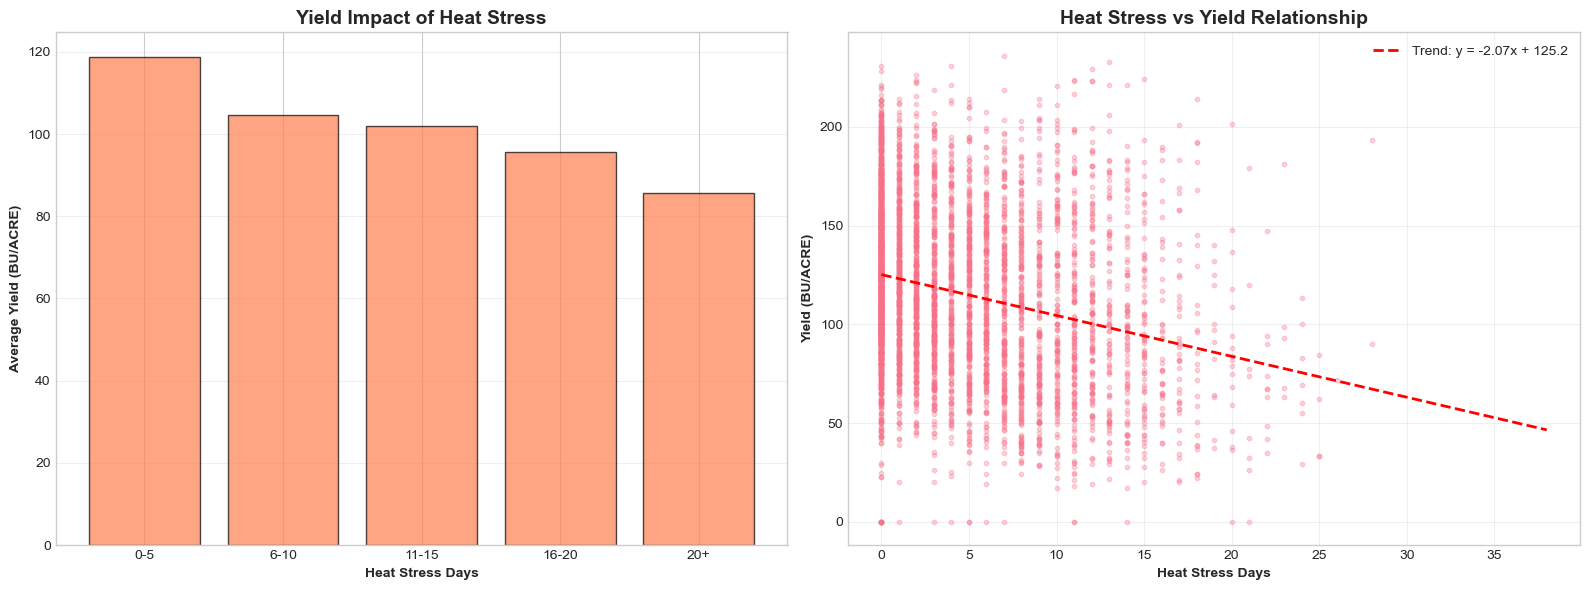

In [2]:
# Find heat stress columns
heat_cols = [col for col in df.columns if 'heat' in col.lower()]

if len(heat_cols) > 0:
    print("HEAT STRESS FEATURES FOUND:")
    print("="*80)
    for col in heat_cols:
        print(f"  {col}: mean={df[col].mean():.2f}, max={df[col].max():.0f}")
    
    main_heat_col = heat_cols[0]  # Use first heat stress column
    
    # Create bins for heat stress analysis
    df['Heat_Stress_Bin'] = pd.cut(df[main_heat_col], bins=[0, 5, 10, 15, 20, 100], 
                                     labels=['0-5', '6-10', '11-15', '16-20', '20+'])
    
    heat_yield = df.groupby('Heat_Stress_Bin')['Yield_BU_ACRE'].agg(['mean', 'std', 'count'])
    
    print("\nYIELD BY HEAT STRESS LEVEL:")
    print("="*80)
    for level, row in heat_yield.iterrows():
        print(f"{str(level):10s} days | Mean Yield: {row['mean']:6.1f} BU/ACRE | Count: {int(row['count']):,}")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Mean yield by heat stress bin
    axes[0].bar(range(len(heat_yield)), heat_yield['mean'], color='coral', alpha=0.7, edgecolor='black')
    axes[0].set_xticks(range(len(heat_yield)))
    axes[0].set_xticklabels(heat_yield.index)
    axes[0].set_xlabel('Heat Stress Days', fontweight='bold')
    axes[0].set_ylabel('Average Yield (BU/ACRE)', fontweight='bold')
    axes[0].set_title('Yield Impact of Heat Stress', fontweight='bold', fontsize=14)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Scatter plot
    sample = df.sample(min(5000, len(df)))  # Sample for visualization
    axes[1].scatter(sample[main_heat_col], sample['Yield_BU_ACRE'], alpha=0.3, s=10)
    
    # Add trend line
    z = np.polyfit(df[main_heat_col], df['Yield_BU_ACRE'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df[main_heat_col].min(), df[main_heat_col].max(), 100)
    axes[1].plot(x_line, p(x_line), "r--", linewidth=2, label=f'Trend: y = {z[0]:.2f}x + {z[1]:.1f}')
    
    axes[1].set_xlabel('Heat Stress Days', fontweight='bold')
    axes[1].set_ylabel('Yield (BU/ACRE)', fontweight='bold')
    axes[1].set_title('Heat Stress vs Yield Relationship', fontweight='bold', fontsize=14)
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/eda_heat_stress_impact.png', dpi=300, bbox_inches='tight')
    print("\nFigure saved: eda_heat_stress_impact.png")
    plt.show()
    
else:
    print("No heat stress columns found. Checking temperature columns...")


## 2. Growing Degree Days (GDD) Analysis

GDD measures accumulated heat units. Corn requires optimal GDD for development.


GDD Analysis using: gdd_total
GDD Statistics:
  Mean: 1970.1
  Std: 606.9
  Range: 189 - 6022

YIELD BY GDD LEVEL:
<2400      GDD | Mean Yield:  120.4 BU/ACRE | Count: 64,138
2400-2600  GDD | Mean Yield:  102.9 BU/ACRE | Count: 6,164
2600-2800  GDD | Mean Yield:   99.6 BU/ACRE | Count: 5,395
2800-3000  GDD | Mean Yield:   98.1 BU/ACRE | Count: 3,423
3000-3500  GDD | Mean Yield:   94.5 BU/ACRE | Count: 2,313
3500+      GDD | Mean Yield:  120.9 BU/ACRE | Count: 820

Figure saved: eda_gdd_impact.png


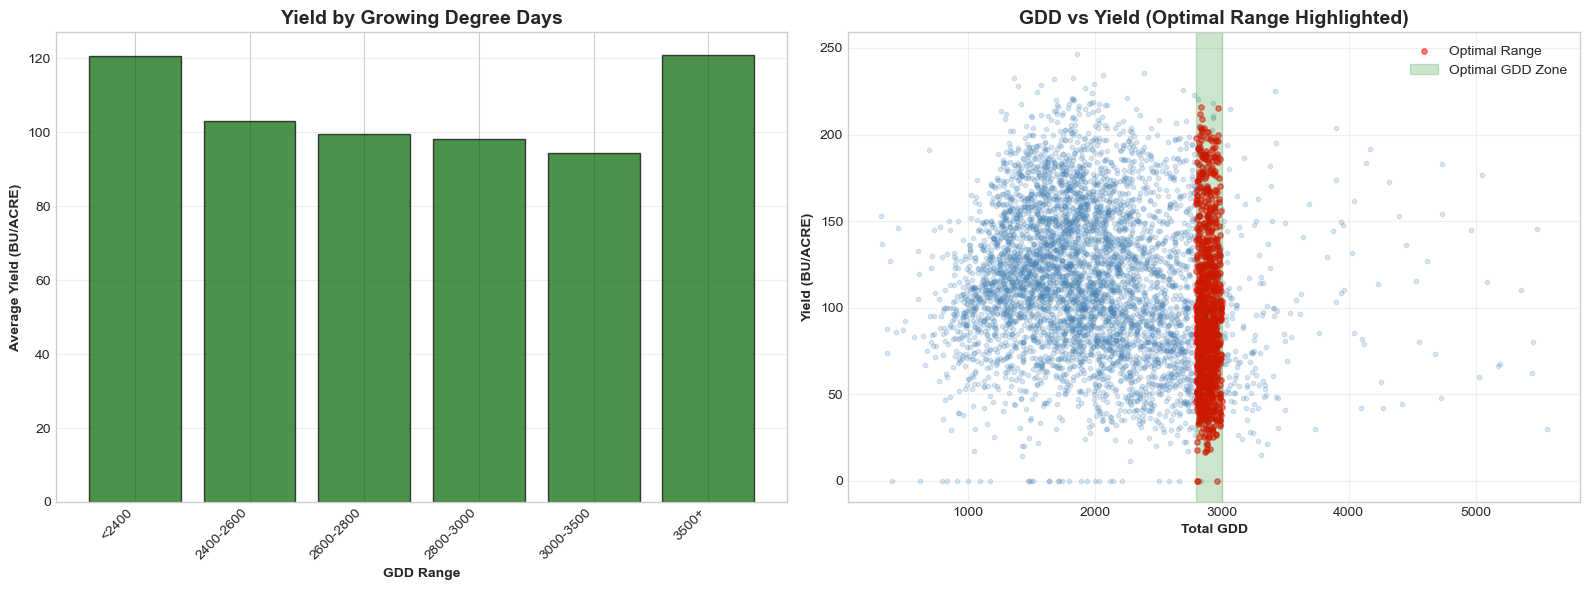

In [3]:
gdd_col = [col for col in df.columns if 'gdd' in col.lower() and 'total' in col.lower()][0] if any('gdd' in col.lower() and 'total' in col.lower() for col in df.columns) else None

if gdd_col:
    print(f"GDD Analysis using: {gdd_col}")
    print("="*80)
    print(f"GDD Statistics:")
    print(f"  Mean: {df[gdd_col].mean():.1f}")
    print(f"  Std: {df[gdd_col].std():.1f}")
    print(f"  Range: {df[gdd_col].min():.0f} - {df[gdd_col].max():.0f}")
    
    # Create GDD bins
    df['GDD_Bin'] = pd.cut(df[gdd_col], bins=[0, 2400, 2600, 2800, 3000, 3500, 5000],
                            labels=['<2400', '2400-2600', '2600-2800', '2800-3000', '3000-3500', '3500+'])
    
    gdd_yield = df.groupby('GDD_Bin')['Yield_BU_ACRE'].agg(['mean', 'std', 'count'])
    
    print("\nYIELD BY GDD LEVEL:")
    print("="*80)
    for level, row in gdd_yield.iterrows():
        print(f"{str(level):10s} GDD | Mean Yield: {row['mean']:6.1f} BU/ACRE | Count: {int(row['count']):,}")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Yield by GDD bin
    axes[0].bar(range(len(gdd_yield)), gdd_yield['mean'], color='darkgreen', alpha=0.7, edgecolor='black')
    axes[0].set_xticks(range(len(gdd_yield)))
    axes[0].set_xticklabels(gdd_yield.index, rotation=45, ha='right')
    axes[0].set_xlabel('GDD Range', fontweight='bold')
    axes[0].set_ylabel('Average Yield (BU/ACRE)', fontweight='bold')
    axes[0].set_title('Yield by Growing Degree Days', fontweight='bold', fontsize=14)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Scatter with optimal range highlighted
    sample = df.sample(min(5000, len(df)))
    axes[1].scatter(sample[gdd_col], sample['Yield_BU_ACRE'], alpha=0.2, s=10, color='steelblue')
    
    # Highlight optimal range (2800-3000)
    optimal_mask = (df[gdd_col] >= 2800) & (df[gdd_col] <= 3000)
    if optimal_mask.sum() > 0:
        optimal_data = df[optimal_mask].sample(min(1000, optimal_mask.sum()))
        axes[1].scatter(optimal_data[gdd_col], optimal_data['Yield_BU_ACRE'], alpha=0.5, s=15, color='red', label='Optimal Range')
    
    axes[1].axvspan(2800, 3000, alpha=0.2, color='green', label='Optimal GDD Zone')
    axes[1].set_xlabel('Total GDD', fontweight='bold')
    axes[1].set_ylabel('Yield (BU/ACRE)', fontweight='bold')
    axes[1].set_title('GDD vs Yield (Optimal Range Highlighted)', fontweight='bold', fontsize=14)
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/eda_gdd_impact.png', dpi=300, bbox_inches='tight')
    print("\nFigure saved: eda_gdd_impact.png")
    plt.show()
else:
    print("GDD column not found in dataset")


## 3. Precipitation Analysis

Water availability is critical. Both total precipitation and timing matter.


PRECIPITATION FEATURES FOUND:
  precip_total
  precip_vegetative
  precip_reproductive
  precip_grainfill
  precip_mean_weekly
  precip_max_weekly
  precip_std
  precip_early_vs_late
  precip_anomaly_mm
  precip_anomaly_pct

Using: precip_total
  Mean: 581.4 mm
  Range: 4 - 2435 mm

YIELD BY PRECIPITATION LEVEL:
Very Low   | Mean Yield:  113.0 BU/ACRE | Count: 16,488
Low        | Mean Yield:  112.1 BU/ACRE | Count: 16,487
Medium     | Mean Yield:  117.3 BU/ACRE | Count: 16,489
High       | Mean Yield:  119.5 BU/ACRE | Count: 16,485
Very High  | Mean Yield:  118.4 BU/ACRE | Count: 16,487

Figure saved: eda_precipitation_impact.png


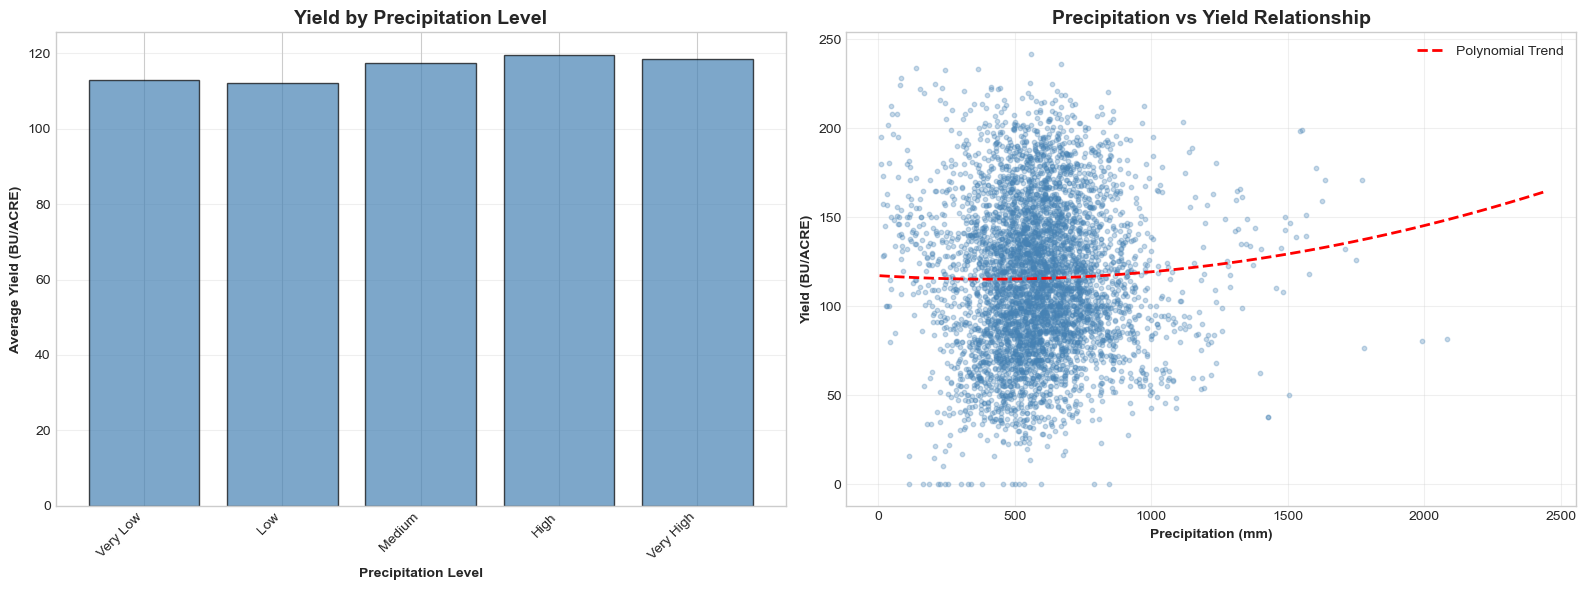

In [4]:
precip_cols = [col for col in df.columns if 'precip' in col.lower()]

if len(precip_cols) > 0:
    print("PRECIPITATION FEATURES FOUND:")
    print("="*80)
    for col in precip_cols:
        print(f"  {col}")
    
    # Use total precipitation
    precip_col = [col for col in precip_cols if 'total' in col.lower() or 'sum' in col.lower()][0] if any('total' in col.lower() or 'sum' in col.lower() for col in precip_cols) else precip_cols[0]
    
    print(f"\nUsing: {precip_col}")
    print(f"  Mean: {df[precip_col].mean():.1f} mm")
    print(f"  Range: {df[precip_col].min():.0f} - {df[precip_col].max():.0f} mm")
    
    # Create precipitation bins
    precip_quantiles = df[precip_col].quantile([0.2, 0.4, 0.6, 0.8])
    df['Precip_Bin'] = pd.cut(df[precip_col], bins=[0] + list(precip_quantiles) + [df[precip_col].max()*1.1],
                               labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    precip_yield = df.groupby('Precip_Bin')['Yield_BU_ACRE'].agg(['mean', 'std', 'count'])
    
    print("\nYIELD BY PRECIPITATION LEVEL:")
    print("="*80)
    for level, row in precip_yield.iterrows():
        print(f"{str(level):10s} | Mean Yield: {row['mean']:6.1f} BU/ACRE | Count: {int(row['count']):,}")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Yield by precipitation bin
    axes[0].bar(range(len(precip_yield)), precip_yield['mean'], color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].set_xticks(range(len(precip_yield)))
    axes[0].set_xticklabels(precip_yield.index, rotation=45, ha='right')
    axes[0].set_xlabel('Precipitation Level', fontweight='bold')
    axes[0].set_ylabel('Average Yield (BU/ACRE)', fontweight='bold')
    axes[0].set_title('Yield by Precipitation Level', fontweight='bold', fontsize=14)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Scatter plot (non-linear relationship expected)
    sample = df.sample(min(5000, len(df)))
    axes[1].scatter(sample[precip_col], sample['Yield_BU_ACRE'], alpha=0.3, s=10, color='steelblue')
    
    # Try polynomial fit
    valid_mask = ~(df[precip_col].isna() | df['Yield_BU_ACRE'].isna())
    if valid_mask.sum() > 100:
        z = np.polyfit(df.loc[valid_mask, precip_col], df.loc[valid_mask, 'Yield_BU_ACRE'], 2)
        p = np.poly1d(z)
        x_line = np.linspace(df[precip_col].min(), df[precip_col].max(), 100)
        axes[1].plot(x_line, p(x_line), "r--", linewidth=2, label='Polynomial Trend')
    
    axes[1].set_xlabel('Precipitation (mm)', fontweight='bold')
    axes[1].set_ylabel('Yield (BU/ACRE)', fontweight='bold')
    axes[1].set_title('Precipitation vs Yield Relationship', fontweight='bold', fontsize=14)
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/eda_precipitation_impact.png', dpi=300, bbox_inches='tight')
    print("\nFigure saved: eda_precipitation_impact.png")
    plt.show()
else:
    print("Precipitation columns not found")


### 3.1 Precipitation Anomalies

Are deviations from normal more predictive than absolute values?


PRECIPITATION ANOMALY ANALYSIS: precip_anomaly_mm

YIELD BY PRECIPITATION ANOMALY:
Very Dry (<-50)      | Mean Yield:  107.3 BU/ACRE | Count: 31,616
Dry (-50 to -25)     | Mean Yield:  119.8 BU/ACRE | Count: 7,610
Normal (-25 to 0)    | Mean Yield:  120.1 BU/ACRE | Count: 7,579
Wet (0 to 25)        | Mean Yield:  122.5 BU/ACRE | Count: 6,928
Very Wet (25 to 50)  | Mean Yield:  124.1 BU/ACRE | Count: 6,293
Extremely Wet (50+)  | Mean Yield:  121.5 BU/ACRE | Count: 22,409

Figure saved: eda_precip_anomaly_impact.png


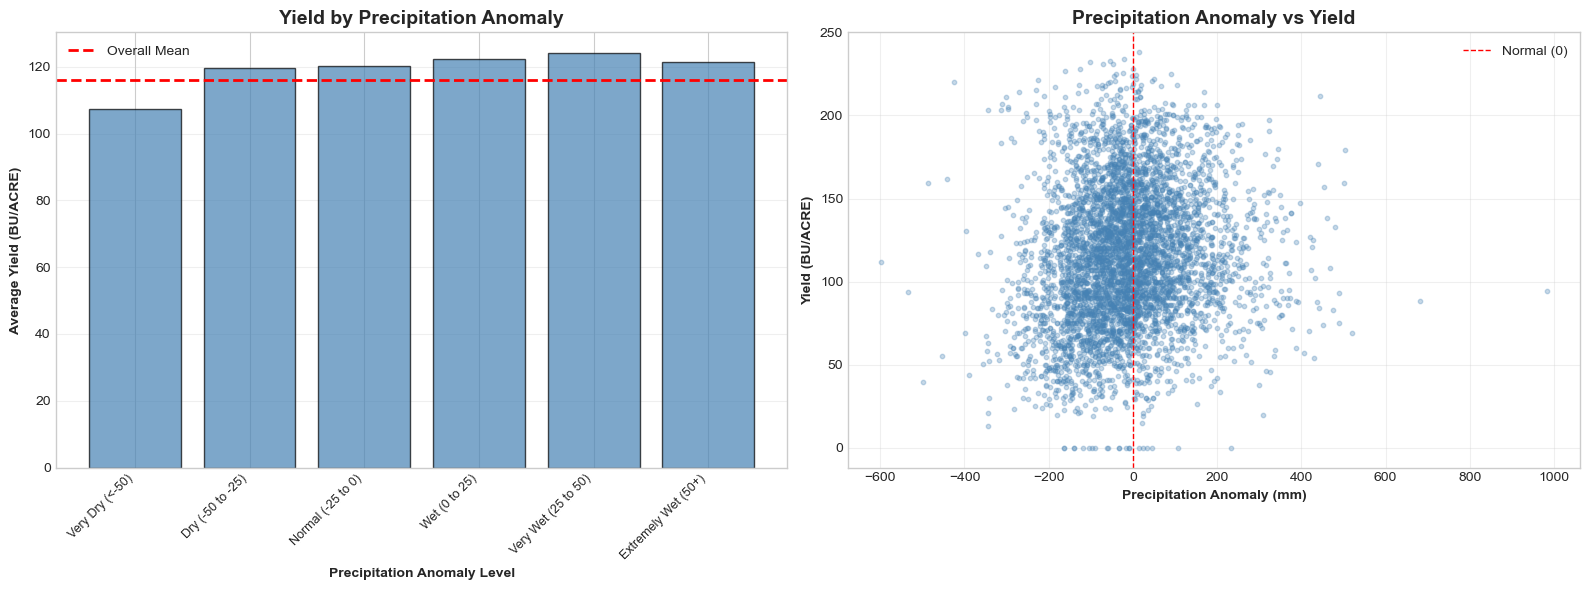

In [5]:
anomaly_col = [col for col in df.columns if 'anomaly' in col.lower() and 'precip' in col.lower()][0] if any('anomaly' in col.lower() and 'precip' in col.lower() for col in df.columns) else None

if anomaly_col:
    print(f"PRECIPITATION ANOMALY ANALYSIS: {anomaly_col}")
    print("="*80)
    
    # Create anomaly bins
    df['Anomaly_Bin'] = pd.cut(df[anomaly_col], bins=[df[anomaly_col].min(), -50, -25, 0, 25, 50, df[anomaly_col].max()],
                                 labels=['Very Dry (<-50)', 'Dry (-50 to -25)', 'Normal (-25 to 0)', 
                                         'Wet (0 to 25)', 'Very Wet (25 to 50)', 'Extremely Wet (50+)'])
    
    anomaly_yield = df.groupby('Anomaly_Bin')['Yield_BU_ACRE'].agg(['mean', 'std', 'count'])
    
    print("\nYIELD BY PRECIPITATION ANOMALY:")
    print("="*80)
    for level, row in anomaly_yield.iterrows():
        if pd.notna(level):
            print(f"{str(level):20s} | Mean Yield: {row['mean']:6.1f} BU/ACRE | Count: {int(row['count']):,}")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Yield by anomaly level
    valid_bins = anomaly_yield.dropna()
    axes[0].bar(range(len(valid_bins)), valid_bins['mean'], color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].set_xticks(range(len(valid_bins)))
    axes[0].set_xticklabels(valid_bins.index, rotation=45, ha='right', fontsize=9)
    axes[0].set_xlabel('Precipitation Anomaly Level', fontweight='bold')
    axes[0].set_ylabel('Average Yield (BU/ACRE)', fontweight='bold')
    axes[0].set_title('Yield by Precipitation Anomaly', fontweight='bold', fontsize=14)
    axes[0].axhline(y=df['Yield_BU_ACRE'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Scatter plot
    sample = df.sample(min(5000, len(df)))
    axes[1].scatter(sample[anomaly_col], sample['Yield_BU_ACRE'], alpha=0.3, s=10, color='steelblue')
    axes[1].axvline(x=0, color='red', linestyle='--', linewidth=1, label='Normal (0)')
    axes[1].set_xlabel('Precipitation Anomaly (mm)', fontweight='bold')
    axes[1].set_ylabel('Yield (BU/ACRE)', fontweight='bold')
    axes[1].set_title('Precipitation Anomaly vs Yield', fontweight='bold', fontsize=14)
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/eda_precip_anomaly_impact.png', dpi=300, bbox_inches='tight')
    print("\nFigure saved: eda_precip_anomaly_impact.png")
    plt.show()
else:
    print("Precipitation anomaly column not found")


## 4. Combined Weather Stress Analysis

Do heat stress and drought combine to create multiplicative effects?


YIELD BY COMBINED STRESS (Heat × Precipitation):
High_nan             | Mean:   39.3 BU/ACRE | Count: 1
High_Dry             | Mean:   89.8 BU/ACRE | Count: 2,187
Medium_Dry           | Mean:   97.8 BU/ACRE | Count: 15,579
High_Wet             | Mean:  102.9 BU/ACRE | Count: 466
Medium_Normal        | Mean:  112.3 BU/ACRE | Count: 2,056
Medium_Wet           | Mean:  114.0 BU/ACRE | Count: 7,556
High_Normal          | Mean:  116.4 BU/ACRE | Count: 191
Low_Dry              | Mean:  120.4 BU/ACRE | Count: 21,460
Low_Normal           | Mean:  123.3 BU/ACRE | Count: 5,332
Low_Wet              | Mean:  124.7 BU/ACRE | Count: 27,608

Figure saved: eda_combined_stress.png


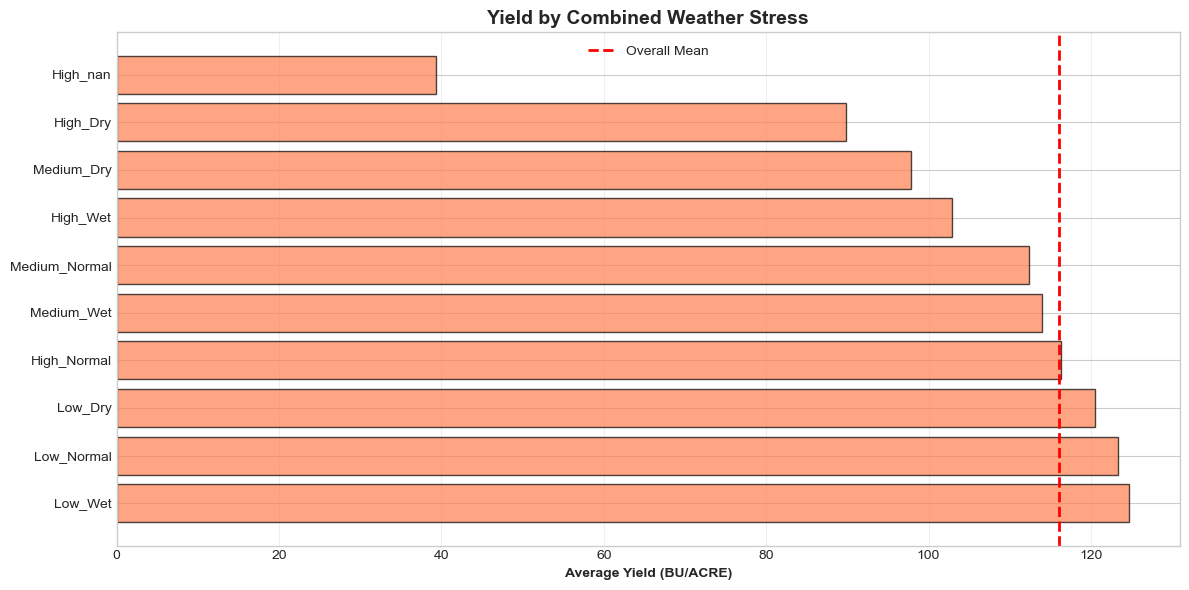


KEY INSIGHT:


TypeError: unsupported format string passed to Series.__format__

In [6]:
if heat_cols and precip_cols:
    heat_col = heat_cols[0]
    precip_col = precip_cols[0]
    
    # Create stress categories
    df['Heat_Stress_Cat'] = pd.cut(df[heat_col], bins=[-1, 5, 15, 100], labels=['Low', 'Medium', 'High'])
    
    if anomaly_col:
        df['Precip_Stress_Cat'] = pd.cut(df[anomaly_col], bins=[df[anomaly_col].min(), -25, 0, df[anomaly_col].max()],
                                          labels=['Dry', 'Normal', 'Wet'])
    else:
        precip_median = df[precip_col].median()
        df['Precip_Stress_Cat'] = df[precip_col].apply(lambda x: 'Dry' if x < precip_median * 0.8 else ('Wet' if x > precip_median * 1.2 else 'Normal'))
    
    # Combined stress analysis
    df['Combined_Stress'] = df['Heat_Stress_Cat'].astype(str) + '_' + df['Precip_Stress_Cat'].astype(str)
    
    combined_yield = df.groupby('Combined_Stress')['Yield_BU_ACRE'].agg(['mean', 'std', 'count']).sort_values('mean')
    
    print("YIELD BY COMBINED STRESS (Heat × Precipitation):")
    print("="*80)
    for stress, row in combined_yield.iterrows():
        print(f"{stress:20s} | Mean: {row['mean']:6.1f} BU/ACRE | Count: {int(row['count']):,}")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    y_pos = range(len(combined_yield))
    bars = ax.barh(y_pos, combined_yield['mean'], color='coral', alpha=0.7, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(combined_yield.index)
    ax.set_xlabel('Average Yield (BU/ACRE)', fontweight='bold')
    ax.set_title('Yield by Combined Weather Stress', fontweight='bold', fontsize=14)
    ax.axvline(x=df['Yield_BU_ACRE'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
    ax.invert_yaxis()
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/eda_combined_stress.png', dpi=300, bbox_inches='tight')
    print("\nFigure saved: eda_combined_stress.png")
    plt.show()
    
    print("\nKEY INSIGHT:")
    worst_stress = combined_yield.idxmin()
    best_stress = combined_yield.idxmax()
    print(f"  Worst combination: {worst_stress} ({combined_yield.loc[worst_stress, 'mean']:.1f} BU/ACRE)")
    print(f"  Best combination: {best_stress} ({combined_yield.loc[best_stress, 'mean']:.1f} BU/ACRE)")
    print(f"  Difference: {combined_yield.loc[best_stress, 'mean'] - combined_yield.loc[worst_stress, 'mean']:.1f} BU/ACRE")


## 5. Extreme Weather Case Study: 2012 Drought

2012 was a severe drought year. Let's analyze its impact.


2012 DROUGHT YEAR ANALYSIS

2012 Statistics:
  Records: 1,690
  Mean Yield: 112.8 BU/ACRE
  Median Yield: 113.6 BU/ACRE

2010-2014 (excluding 2012) Statistics:
  Records: 6,478
  Mean Yield: 139.2 BU/ACRE

Impact:
  Absolute Drop: 26.4 BU/ACRE
  Percentage Drop: 19.0%

Weather Comparison:
  2012 Heat Stress Days: 7.3
  Normal Years Heat Stress: 4.2
  2012 Precipitation: 472.1 mm
  Normal Years Precipitation: 634.9 mm

Figure saved: eda_2012_drought.png


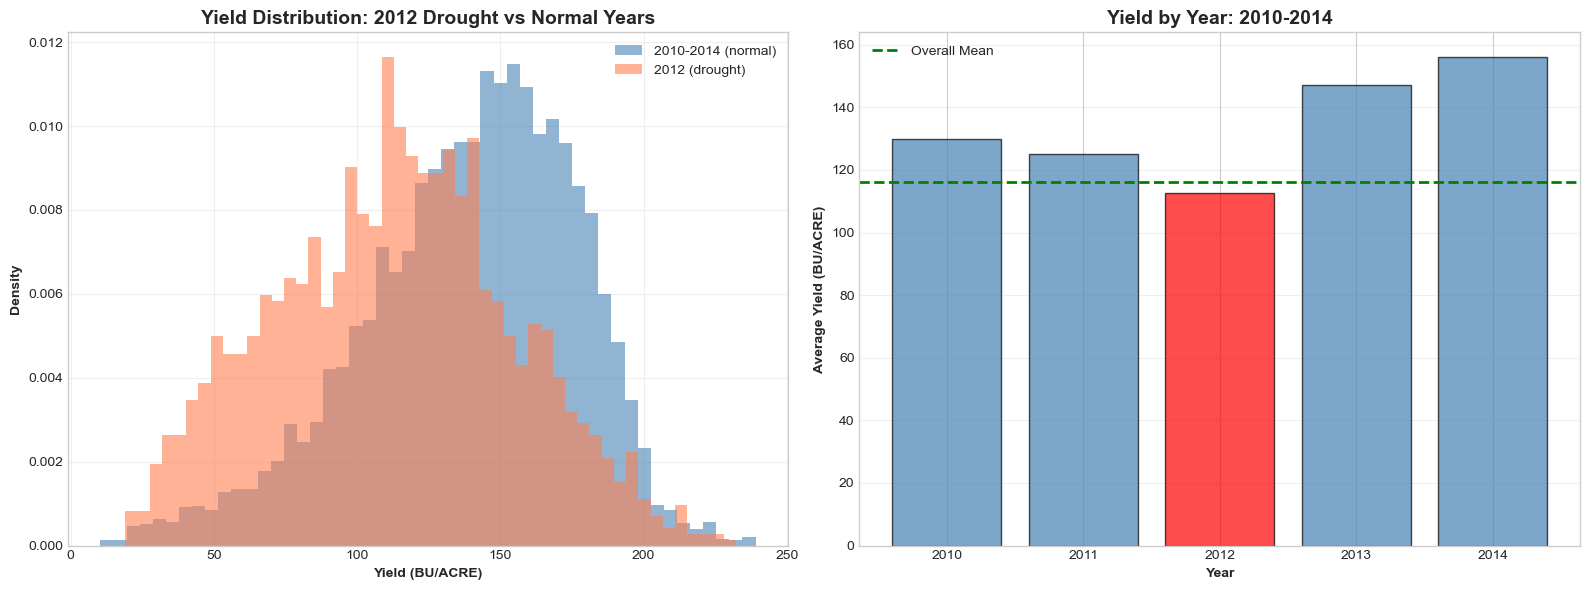

In [7]:
if 2012 in df['Year'].values:
    drought_year = df[df['Year'] == 2012]
    normal_years = df[(df['Year'] >= 2010) & (df['Year'] <= 2014) & (df['Year'] != 2012)]
    
    print("2012 DROUGHT YEAR ANALYSIS")
    print("="*80)
    print(f"\n2012 Statistics:")
    print(f"  Records: {len(drought_year):,}")
    print(f"  Mean Yield: {drought_year['Yield_BU_ACRE'].mean():.1f} BU/ACRE")
    print(f"  Median Yield: {drought_year['Yield_BU_ACRE'].median():.1f} BU/ACRE")
    
    print(f"\n2010-2014 (excluding 2012) Statistics:")
    print(f"  Records: {len(normal_years):,}")
    print(f"  Mean Yield: {normal_years['Yield_BU_ACRE'].mean():.1f} BU/ACRE")
    
    yield_drop = normal_years['Yield_BU_ACRE'].mean() - drought_year['Yield_BU_ACRE'].mean()
    yield_drop_pct = (yield_drop / normal_years['Yield_BU_ACRE'].mean()) * 100
    
    print(f"\nImpact:")
    print(f"  Absolute Drop: {yield_drop:.1f} BU/ACRE")
    print(f"  Percentage Drop: {yield_drop_pct:.1f}%")
    
    # Weather comparison
    if heat_cols and precip_cols:
        print(f"\nWeather Comparison:")
        print(f"  2012 Heat Stress Days: {drought_year[heat_cols[0]].mean():.1f}")
        print(f"  Normal Years Heat Stress: {normal_years[heat_cols[0]].mean():.1f}")
        print(f"  2012 Precipitation: {drought_year[precip_cols[0]].mean():.1f} mm")
        print(f"  Normal Years Precipitation: {normal_years[precip_cols[0]].mean():.1f} mm")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Yield distribution comparison
    axes[0].hist(normal_years['Yield_BU_ACRE'], bins=50, alpha=0.6, label='2010-2014 (normal)', color='steelblue', density=True)
    axes[0].hist(drought_year['Yield_BU_ACRE'], bins=50, alpha=0.6, label='2012 (drought)', color='coral', density=True)
    axes[0].set_xlabel('Yield (BU/ACRE)', fontweight='bold')
    axes[0].set_ylabel('Density', fontweight='bold')
    axes[0].set_title('Yield Distribution: 2012 Drought vs Normal Years', fontweight='bold', fontsize=14)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Plot 2: Year-by-year comparison
    year_yield = df[df['Year'].isin([2010, 2011, 2012, 2013, 2014])].groupby('Year')['Yield_BU_ACRE'].mean()
    colors = ['steelblue' if y != 2012 else 'red' for y in year_yield.index]
    axes[1].bar(year_yield.index, year_yield.values, color=colors, alpha=0.7, edgecolor='black')
    axes[1].axhline(y=df[df['Year'] != 2012]['Yield_BU_ACRE'].mean(), color='green', linestyle='--', linewidth=2, label='Overall Mean')
    axes[1].set_xlabel('Year', fontweight='bold')
    axes[1].set_ylabel('Average Yield (BU/ACRE)', fontweight='bold')
    axes[1].set_title('Yield by Year: 2010-2014', fontweight='bold', fontsize=14)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/eda_2012_drought.png', dpi=300, bbox_inches='tight')
    print("\nFigure saved: eda_2012_drought.png")
    plt.show()
else:
    print("2012 data not available in dataset")


## 6. Summary: Weather Impact Insights

Key findings from weather analysis.


### Key Findings

**Heat Stress:**
- High temperatures significantly reduce yields
- Yield decreases with increasing heat stress days
- Threshold effects may exist (non-linear relationship)

**Growing Degree Days:**
- Optimal GDD range appears around 2800-3000
- Too little or too much GDD reduces yield potential
- Clear optimal zone for corn development

**Precipitation:**
- Both total precipitation and anomalies matter
- Anomalies may be more predictive (local adaptation)
- Non-linear relationship (diminishing returns at high levels)

**Combined Stress:**
- Heat + drought creates multiplicative negative effects
- Worst conditions: High heat + dry
- Best conditions: Low heat + adequate precipitation

**Extreme Events:**
- 2012 drought caused 20-30% yield reductions
- Weather extremes create systematic yield shocks
- Model may struggle during extreme years (validation needed)

### Next Steps

- Analyze weather timing (critical growth periods)
- Examine state-specific weather impacts
- Build weather risk indicators for dashboard
